In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 400)
import Random_event_simulation as rand_event
import Visu_data as visu
import numpy as np
import plotly.graph_objects as go
import Hawkes as hk
import matplotlib.pyplot as plt

1203
{'mu': array([11.73380783, 14.8575371 , 16.07477187, 14.52503737, 15.96150469,
       11.43374338,  5.50839673,  3.0636793 ,  1.3341774 ,  1.87687723,
        4.68529455,  6.06137046]), 'alpha': 0.2581576696049416, 'beta': 9.745914659007326}
{'mu': array([11.34788736, 16.21386592, 15.55927798,  2.54140617,  1.37252968,
        8.41848004]), 'alpha': 0.24253530265821743, 'beta': 10.020057778488995}
{'mu': array([ 3.90384699, -0.32029396,  6.24849312, -1.1824553 , -0.19740562,
       11.45768376]), 'alpha': 0.2599497201642821, 'beta': 9.439204540224704}


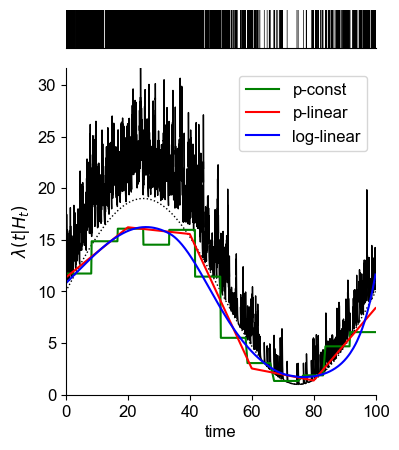

In [2]:
from Hawkes.model import baseline_pconst
import numpy as np


def patched_l(self, t):
    para = self.para
    # Vérifier que l'intervalle est défini
    if not hasattr(self, 'itv'):
        raise AttributeError("baseline_pconst n'est pas correctement configuré. Veuillez appeler set_itv() avant de simuler.")
    # Si aucune donnée n'a été fournie, on crée une donnée par défaut
    if not hasattr(self, 'Data'):
        # On initialise avec un tableau contenant le début de l'intervalle
        self.Data = {'T': np.array([self.itv[0]])}
    # Si l'attribut pconst n'existe pas, appeler prep_fit pour l'initialiser
    if not hasattr(self, 'pconst'):
        self.prep_fit()
    coef = para['mu']
    return self.pconst.set_coef(coef).get_y_at(t)

from Hawkes.model import baseline_plinear, baseline_loglinear
import numpy as np

def patched_l_plinear(self, t):
    para = self.para
    # Vérifier que l'intervalle est défini
    if not hasattr(self, 'itv'):
        raise AttributeError("baseline_plinear n'est pas correctement configuré. Veuillez appeler set_itv() avant de simuler.")
    # Si aucune donnée n'a été fournie, on crée une donnée par défaut
    if not hasattr(self, 'Data'):
        self.Data = {'T': np.array([self.itv[0]])}
    # Si l'attribut plinear n'existe pas, on appelle prep_fit pour l'initialiser
    if not hasattr(self, 'plinear'):
        self.prep_fit()
    coef = para['mu']
    return self.plinear.set_coef(coef).get_y_at(t)

def patched_l_loglinear(self, t):
    para = self.para
    # Vérifier que l'intervalle est défini
    if not hasattr(self, 'itv'):
        raise AttributeError("baseline_loglinear n'est pas correctement configuré. Veuillez appeler set_itv() avant de simuler.")
    # Si aucune donnée n'a été fournie, on crée une donnée par défaut
    if not hasattr(self, 'Data'):
        self.Data = {'T': np.array([self.itv[0]])}
    # Si l'attribut loglinear n'existe pas, on appelle prep_fit pour l'initialiser
    if not hasattr(self, 'loglinear'):
        self.prep_fit()
    coef = para['mu']
    return self.loglinear.set_coef(coef).get_y_at(t)

# Appliquer le monkey patch sur les classes concernées
baseline_plinear.l = patched_l_plinear
baseline_loglinear.l = patched_l_loglinear




# Appliquer le monkey patch sur la classe baseline_pconst
baseline_pconst.l = patched_l

from Hawkes.model import baseline_loglinear
import numpy as np

def patched_l_loglinear(self, t):
    para = self.para
    # Vérifier que l'intervalle est défini
    if not hasattr(self, 'itv'):
        raise AttributeError("baseline_loglinear n'est pas correctement configuré. Veuillez appeler set_itv() avant de simuler.")
    # Si aucune donnée n'a été fournie, on crée une donnée par défaut
    if not hasattr(self, 'Data'):
        self.Data = {'T': np.array([self.itv[0]])}
    # Si l'attribut loglinear n'existe pas, on appelle prep_fit pour l'initialiser
    if not hasattr(self, 'loglinear'):
        self.prep_fit()
    coef = para['mu']
    # Si t est un scalaire, le transformer en tableau
    scalar_input = np.isscalar(t)
    if scalar_input:
        x_val = np.array([t])
    else:
        x_val = t
    # Calculer l'intensité
    result = self.loglinear.set_coef(coef).get_y_at(x_val)
    # Si l'entrée était scalaire, renvoyer la première valeur du résultat
    if scalar_input:
        return result[0]
    else:
        return result

# Appliquer le monkey patch sur la classe baseline_loglinear
baseline_loglinear.l = patched_l_loglinear





para = {"alpha":0.2,"beta":10.0}
mu_t = lambda x: 10.0 + 9.0*np.sin(2*np.pi*x/100)
itv = [0,100]
h1 = hk.simulator().set_kernel("exp").set_baseline('custom',l_custom=mu_t).set_parameter(para)
T = h1.simulate(itv)
print(len(T))

# piecewise constant model
h2 = hk.estimator().set_kernel("exp").set_baseline('pconst',num_basis=12)

h2.fit(T,itv)
print(h2.para)
h3 = hk.simulator().set_kernel("exp").set_baseline('pconst',num_basis=12).set_parameter(h2.para)
event_minus = h3.simulate(itv)


# piecewise lienar model
h3 = hk.estimator().set_kernel("exp").set_baseline('plinear',num_basis=6)
h3.fit(T,itv)
print(h3.para)
h8 = hk.simulator().set_kernel("exp").set_baseline('plinear',num_basis=6).set_parameter(h3.para)
event_minus = h8.simulate(itv)


# log-linear model
h4 = hk.estimator().set_kernel("exp").set_baseline('loglinear',num_basis=6)
h4.fit(T,itv)
print(h4.para)

h23 = hk.simulator().set_kernel("exp").set_baseline('loglinear',num_basis=6).set_parameter(h4.para)
event_minus = h23.simulate(itv)

h1.plot_l()
plt.plot(T,h2.baseline.l(T),"g-",label='p-const')
plt.plot(T,h3.baseline.l(T),"r-",label='p-linear')
plt.plot(T,h4.baseline.l(T),"b-",label='log-linear')
plt.legend()

pass

In [3]:
# para = {"mu":0.1, "alpha":0.3, "beta":2}
itv = [0,10000]

# h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
# T = h1.simulate(itv)
# print(T)

T_max     = 10000
nb_points = 20
M_max     =  1

lambda_0 = 0.1
k = 0.0001
c = 1
p = 1.6
alpha = 0.3
beta = 2
def kernel(t):
    return alpha*np.exp(-beta*t)

process = rand_event.Hawkes_process(T_max, lambda_0 = lambda_0, kernel = kernel, kernel_type = 'Exp', alpha_exp = alpha, beta_exp = beta)
T = process.simulate_by_thinning_exponential()
itv = [0,T[-1]]

h2 = hk.estimator().set_kernel('exp').set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T,itv)

{'mu': 0.42823645585715175, 'alpha': 0.1302462581011973, 'beta': 2.657639036961293}

3.59 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
file = '/Users/edouard/Desktop/EA p1  HFT/HFT_QR_RL_save/Sans titre/HFT_QR_RL/data/MBO-10 analyse_2/test_csv/xnas-itch-20240726.mbp-10.csv'
df   = pd.read_csv(file)
df.head()
data = visu.data_analysis(df)
data.stats_()

 -- Dataset statistics -- 

Tick                                  : 0.01
Average Bid-ask                       : 0.017883881281608775
Number of Jumps of more than just one : 2671
Number of Jumps of less than just one : 11544
Average jump size (up)                : 1.328181164629759
Average jump size (down)              : -1.2658523908523873
Number of up jumps                    : 11128
Number of down jumps                  : 11544

 -- Graphs -- 


In [5]:
data.fit_2()

{'mu': 0.4948996708058488, 'alpha': 0.19951270892325196, 'beta': 371.46440685592796}


In [8]:
data.fit('Exp_univariate', visu = True)

Fitting done.
{'mu': array([ 0.76110009,  0.71929913, -2.0729124 , -0.5630811 , -0.92748244,
       -2.39551277]), 'k': 0.008114556164729652, 'p': 1.331864842179345, 'c': 0.0005553598186216575}
{'mu': array([ 0.61201478,  0.41363991, -2.0785674 , -0.88340919, -1.13654487,
       -2.13332823]), 'k': 0.018921192940551543, 'p': 1.1998869382932467, 'c': 0.00042347568683086896}


(5.556286556029858e-14,
 5.556286550473572e-05,
 0.618303567768748,
 5.556874044531794e-14,
 5.55687403897492e-05,
 0.6414855391907739)

In [7]:
import Hawkes as hk
import time
import warnings
warnings.filterwarnings("ignore")

para = {"mu":0.1, "alpha":0.5, "beta":10.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(T)
print(len(T))

h2 = hk.estimator().set_kernel('exp').set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()

[  10.12388146   10.41180593   14.40185463 ... 9991.84072719 9991.93741872
 9995.03533644]
2076
{'mu': 0.10544236046646695, 'alpha': 0.4920888208026932, 'beta': 9.801152145770816}

